#**<center>Natural Language Text to SQL Query Conversion**
##**<center>Augmented Pointer Network Model**

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
pip install 'sqlalchemy>=1.3.0,<1.4.0' --force-reinstall

  Using cached https://files.pythonhosted.org/packages/31/44/a86070dda790ce94cd7d9fb9281cd614c7d30850ed774ace9a84d0d5d491/SQLAlchemy-1.3.24-cp37-cp37m-manylinux2010_x86_64.whl
  Found existing installation: SQLAlchemy 1.3.24
    Uninstalling SQLAlchemy-1.3.24:
      Successfully uninstalled SQLAlchemy-1.3.24


In [3]:
pip install records

In [4]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import records
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import time
import unicodedata

from __future__ import unicode_literals, print_function, division

from collections import defaultdict
from io import open
from __future__ import unicode_literals, print_function, division

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from torch.autograd import Variable
from torch import optim

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
import os
import sys
sys.path.append('/content/drive/MyDrive/lib/')

In [8]:
from lib_project import *

In [9]:
#constants
MAX_LENGTH = 50
teacher_forcing_ratio = 1
GPU = True
BATCH_SIZE = 64
TRAINING_EPOCHS = 30
LEARNING_RATE = 1e-3

In [10]:
SOS_token = 0
EOS_token = 1

##**Function to plot graphs**

In [11]:


def plot_data(x, y, xlabel = "x", ylabel = "y", label = 'plot'):
	plt.figure()
	plt.plot(x, y)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	print("\nGenerating plot for ", label)
	plt.savefig("./" + label + ".png")

##**Aggregation Predictor model**

In [12]:
class AggregationPredictor(nn.Module):
    def __init__(self, N_word, N_h, N_depth):
        super(AggregationPredictor, self).__init__()

        self.agg_lstm = nn.LSTM(input_size=N_word, hidden_size=N_h // 2,
                                num_layers=N_depth, batch_first=True,
                                dropout=0.3, bidirectional=True)

        self.agg_att = nn.Linear(N_h, 1)
        self.agg_out = nn.Sequential(nn.Linear(N_h, N_h), nn.Tanh(), nn.Linear(N_h, 6))
        self.softmax = nn.Softmax()

    def forward(self, x_emb_var, x_len, col_inp_var=None, col_name_len=None, col_len=None, col_num=None, ground_truth_sel=None):
        B = len(x_emb_var)
        max_x_len = max(x_len)

        h_enc, _ = run_lstm(self.agg_lstm, x_emb_var, x_len)
        att_val = self.agg_att(h_enc).squeeze()

        for idx, num in enumerate(x_len):
            if num < max_x_len:
                att_val[idx, num:] = -100
        att = self.softmax(att_val)

        K_agg = (h_enc * att.unsqueeze(2).expand_as(h_enc)).sum(1)
        agg_score = self.agg_out(K_agg)
        return agg_score
        

##**Selection Predictor Model**

In [13]:
class SelectionClausePredictor(nn.Module):
    def __init__(self, N_word, N_h, N_depth, max_tok_num):
        super(SelectionClausePredictor, self).__init__()
        self.max_tok_num = max_tok_num
        self.sel_lstm = nn.LSTM(input_size=N_word, hidden_size=N_h // 2, num_layers=N_depth, batch_first=True,
                                dropout=0.3, bidirectional=True)
        self.sel_att = nn.Linear(N_h, 1)
        self.sel_col_name_enc = nn.LSTM(input_size=N_word, hidden_size=N_h // 2,
                                        num_layers=N_depth, batch_first=True,
                                        dropout=0.3, bidirectional=True)
        self.sel_out_K = nn.Linear(N_h, N_h)
        self.sel_out_col = nn.Linear(N_h, N_h)
        self.sel_out = nn.Sequential(nn.Tanh(), nn.Linear(N_h, 1))
        self.softmax = nn.Softmax()

    def forward(self, x_emb_var, x_len, col_inp_var,
                col_name_len, col_len, col_num):
        B = len(x_emb_var)
        max_x_len = max(x_len)

        e_col, _ = col_name_encode(col_inp_var, col_name_len,
                                   col_len, self.sel_col_name_enc)

        h_enc, _ = run_lstm(self.sel_lstm, x_emb_var, x_len)
        att_val = self.sel_att(h_enc).squeeze()
        for idx, num in enumerate(x_len):
            if num < max_x_len:
                att_val[idx, num:] = -100
        att = self.softmax(att_val)
        K_sel = (h_enc * att.unsqueeze(2).expand_as(h_enc)).sum(1)
        K_sel_expand = K_sel.unsqueeze(1)

        sel_score = self.sel_out(self.sel_out_K(K_sel_expand) + \
                                 self.sel_out_col(e_col)).squeeze()
        max_col_num = max(col_num)
        for idx, num in enumerate(col_num):
            if num < max_col_num:
                sel_score[idx, num:] = -100

        return sel_score

##**Condition Predictor model**

In [14]:
class ConditionPredictor(nn.Module):
    def __init__(self, N_word, N_h, N_depth, max_col_num, max_tok_num, gpu):
        super(ConditionPredictor, self).__init__()
        print("txtsql where prediction")
        self.N_h = N_h
        self.max_tok_num = max_tok_num
        self.max_col_num = max_col_num
        self.gpu = gpu

        self.cond_lstm = nn.LSTM(input_size=N_word, hidden_size=N_h // 2,
                                 num_layers=N_depth, batch_first=True,
                                 dropout=0.3, bidirectional=True)
        self.cond_decoder = nn.LSTM(input_size=self.max_tok_num,
                                    hidden_size=N_h, num_layers=N_depth,
                                    batch_first=True, dropout=0.3)

        self.cond_out_g = nn.Linear(N_h, N_h)
        self.cond_out_h = nn.Linear(N_h, N_h)
        self.cond_out = nn.Sequential(nn.Tanh(), nn.Linear(N_h, 1))

        self.softmax = nn.Softmax()

    def gen_ground_truth_batch(self, tok_seq, gen_inp=True):
        B = len(tok_seq)
        ret_len = np.array([len(one_tok_seq) - 1 for one_tok_seq in tok_seq])
        max_len = max(ret_len)
        ret_array = np.zeros((B, max_len, self.max_tok_num), dtype=np.float32)
        for b, one_tok_seq in enumerate(tok_seq):
            out_one_tok_seq = one_tok_seq[:-1] if gen_inp else one_tok_seq[1:]
            for t, tok_id in enumerate(out_one_tok_seq):
                ret_array[b, t, tok_id] = 1

        ret_inp = torch.from_numpy(ret_array)
        if self.gpu:
            ret_inp = ret_inp.cuda()
        ret_inp_var = Variable(ret_inp)

        return ret_inp_var, ret_len

    def forward(self, x_emb_var, x_len, col_inp_var, col_name_len, col_len,
                col_num, ground_truth_where, ground_truth_cond):
        max_x_len = max(x_len)
        B = len(x_len)

        h_enc, hidden = run_lstm(self.cond_lstm, x_emb_var, x_len)
        decoder_hidden = tuple(torch.cat((hid[:2], hid[2:]), dim=2)
                               for hid in hidden)
        if ground_truth_where is not None:
            ground_truth_tok_seq, ground_truth_tok_len = self.gen_ground_truth_batch(ground_truth_where, gen_inp=True)
            g_s, _ = run_lstm(self.cond_decoder,
                              ground_truth_tok_seq, ground_truth_tok_len, decoder_hidden)

            h_enc_expand = h_enc.unsqueeze(1)
            g_s_expand = g_s.unsqueeze(2)
            cond_score = self.cond_out(self.cond_out_h(h_enc_expand) +
                                       self.cond_out_g(g_s_expand)).squeeze()
            for idx, num in enumerate(x_len):
                if num < max_x_len:
                    cond_score[idx, :, num:] = -100
        else:
            h_enc_expand = h_enc.unsqueeze(1)
            scores = []
            done_set = set()

            t = 0
            init_inp = np.zeros((B, 1, self.max_tok_num), dtype=np.float32)
            init_inp[:, 0, 7] = 1  # Set the <BEG> token
            if self.gpu:
                cur_inp = Variable(torch.from_numpy(init_inp).cuda())
            else:
                cur_inp = Variable(torch.from_numpy(init_inp))
            cur_h = decoder_hidden
            while len(done_set) < B and t < 100:
                g_s, cur_h = self.cond_decoder(cur_inp, cur_h)
                g_s_expand = g_s.unsqueeze(2)

                cur_cond_score = self.cond_out(self.cond_out_h(h_enc_expand) +
                                               self.cond_out_g(g_s_expand)).squeeze()
                for b, num in enumerate(x_len):
                    if num < max_x_len:
                        cur_cond_score[b, num:] = -100
                scores.append(cur_cond_score)

                _, ans_tok_var = cur_cond_score.view(B, max_x_len).max(1)
                ans_tok_var = ans_tok_var.unsqueeze(1)

                ans_tok = ans_tok_var.data.cpu()
                if self.gpu:  # To one-hot
                    cur_inp = Variable(torch.zeros(
                        B, self.max_tok_num).scatter_(1, ans_tok, 1).cuda())
                else:
                    cur_inp = Variable(torch.zeros(
                        B, self.max_tok_num).scatter_(1, ans_tok, 1))
                cur_inp = cur_inp.unsqueeze(1)

                for idx, tok in enumerate(ans_tok.squeeze()):
                    if tok == 1:  # Find the <END> token
                        done_set.add(idx)
                t += 1

            cond_score = torch.stack(scores, 1)

        return cond_score
        



##**txtsql model comprising of three models** 

In [15]:
class txtsql(nn.Module):
    """
    txtsql Model which is internally comprised of three individual models
    1. Aggregation predictor
    2. Selection Predictor
    3. Condition Predictor
    """
    def __init__(self, emb, N_word, N_h=100, N_depth=2,
                 gpu=False):
        super(txtsql, self).__init__()

        self.gpu = gpu
        self.N_h = N_h
        self.N_depth = N_depth

        self.maximum_column_count = 45
        self.maximum_token_count = 200
        self.SQL_SYNTAX_TOKENS = [
            '<UNK>', '<END>', 'WHERE', 'AND',
            'EQL', 'GT', 'LT', '<BEG>'
        ]

        # Word embedding
        self.embed_layer = Embedding(emb, N_word, gpu, self.SQL_SYNTAX_TOKENS, our_model=False)

        # Model for predicting aggregation clause
        self.agg_pred = AggregationPredictor(N_word, N_h, N_depth)

        # Model for predicting select columns
        self.sel_pred = SelectionClausePredictor(N_word, N_h, N_depth, self.maximum_token_count)

        # Model for predicting the conditions
        self.cond_pred = ConditionPredictor(N_word, N_h, N_depth, self.maximum_column_count, self.maximum_token_count, gpu)

        # Loss function
        self.CE = nn.CrossEntropyLoss()
        if gpu:
            self.cuda()

    def generate_ground_truth_where_seq(self, q, col, query):
        ret_seq = []
        for cur_q, cur_col, cur_query in zip(q, col, query):
            connect_col = [tok for col_tok in cur_col for tok in col_tok + [',']]
            all_toks = self.SQL_SYNTAX_TOKENS + connect_col + [None] + cur_q + [None]
            cur_seq = [all_toks.index('<BEG>')]
            if 'WHERE' in cur_query:
                cur_where_query = cur_query[cur_query.index('WHERE'):]
                cur_seq = cur_seq + list(map(lambda tok: all_toks.index(tok)
                if tok in all_toks else 0, cur_where_query))
            cur_seq.append(all_toks.index('<END>'))
            ret_seq.append(cur_seq)
        return ret_seq

    def forward(self, q, col, col_num, ground_truth_where=None, ground_truth_cond=None, ground_truth_sel=None):
        x_emb_var, x_len = self.embed_layer.gen_x_batch(q, col)
        batch = self.embed_layer.gen_col_batch(col)
        col_inp_var, col_name_len, col_len = batch

        agg_score = self.agg_pred(x_emb_var, x_len)

        sel_score = self.sel_pred(x_emb_var, x_len, col_inp_var, col_name_len, col_len, col_num)

        cond_score = self.cond_pred(x_emb_var, x_len, col_inp_var, col_name_len, col_len, col_num, ground_truth_where, ground_truth_cond)

        return (agg_score, sel_score, cond_score)

    def loss(self, score, truth_num, ground_truth_where):
        agg_score, sel_score, cond_score = score
        loss = 0
        agg_truth = list(map(lambda x: x[0], truth_num))
        data = torch.from_numpy(np.array(agg_truth))
        if self.gpu:
            agg_truth_var = Variable(data.cuda())
        else:
            agg_truth_var = Variable(data)

        loss += self.CE(agg_score, agg_truth_var.long())

        sel_truth = list(map(lambda x: x[1], truth_num))
        data = torch.from_numpy(np.array(sel_truth))
        if self.gpu:
            sel_truth_var = Variable(data).cuda()
        else:
            sel_truth_var = Variable(data)

        loss += self.CE(sel_score, sel_truth_var.long())

        for b in range(len(ground_truth_where)):
            if self.gpu:
                cond_truth_var = Variable(torch.from_numpy(np.array(ground_truth_where[b][1:])).cuda())
            else:
                cond_truth_var = Variable(torch.from_numpy(np.array(ground_truth_where[b][1:])))
            cond_pred_score = cond_score[b, :len(ground_truth_where[b]) - 1]

            loss += (self.CE(
                cond_pred_score, cond_truth_var.long()) / len(ground_truth_where))

        return loss

    def check_accuracy(self, pred_queries, ground_truth_queries):
        tot_err = agg_err = sel_err = cond_err = cond_num_err = \
            cond_col_err = cond_op_err = cond_val_err = 0.0
        for b, (pred_qry, ground_truth_qry) in enumerate(zip(pred_queries, ground_truth_queries)):
            good = True

            agg_pred = pred_qry['agg']
            agg_gt = ground_truth_qry['agg']
            if agg_pred != agg_gt:
                agg_err += 1
                good = False

            sel_pred = pred_qry['sel']
            sel_gt = ground_truth_qry['sel']
            if sel_pred != sel_gt:
                sel_err += 1
                good = False

            cond_pred = pred_qry['conds']
            cond_gt = ground_truth_qry['conds']
            flag = True
            if len(cond_pred) != len(cond_gt):
                flag = False
                cond_num_err += 1

            if flag and set(
                    x[0] for x in cond_pred) != set(x[0] for x in cond_gt):
                flag = False
                cond_col_err += 1

            for idx in range(len(cond_pred)):
                if not flag:
                    break
                ground_truth_idx = tuple(x[0] for x in cond_gt).index(cond_pred[idx][0])
                if flag and cond_gt[ground_truth_idx][1] != cond_pred[idx][1]:
                    flag = False
                    cond_op_err += 1

            for idx in range(len(cond_pred)):
                if not flag:
                    break
                ground_truth_idx = tuple(x[0] for x in cond_gt).index(cond_pred[idx][0])
                if flag and str(cond_gt[ground_truth_idx][2]).lower() != \
                        str(cond_pred[idx][2]).lower():
                    flag = False
                    cond_val_err += 1

            if not flag:
                cond_err += 1
                good = False

            if not good:
                tot_err += 1

        return np.array((agg_err, sel_err, cond_err)), tot_err

    def gen_query(self, score, q, col, raw_q, raw_col, verbose=False):
        def merge_tokens(tok_list, raw_tok_str):
            tok_str = raw_tok_str.lower()
            alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789$('
            special = {'-LRB-': '(', '-RRB-': ')', '-LSB-': '[', '-RSB-': ']',
                       '``': '"', '\'\'': '"', '--': u'\u2013'}
            ret = ''
            double_quote_appear = 0
            for raw_tok in tok_list:
                if not raw_tok:
                    continue
                tok = special.get(raw_tok, raw_tok)
                if tok == '"':
                    double_quote_appear = 1 - double_quote_appear

                if len(ret) == 0:
                    pass
                elif len(ret) > 0 and ret + ' ' + tok in tok_str:
                    ret = ret + ' '
                elif len(ret) > 0 and ret + tok in tok_str:
                    pass
                elif tok == '"':
                    if double_quote_appear:
                        ret = ret + ' '
                elif tok[0] not in alphabet:
                    pass
                elif (ret[-1] not in ['(', '/', u'\u2013', '#', '$', '&']) and \
                        (ret[-1] != '"' or not double_quote_appear):
                    ret = ret + ' '
                ret = ret + tok
            return ret.strip()

        agg_score, sel_score, cond_score = score

        ret_queries = []
        B = len(cond_score)
        for b in range(B):
            cur_query = {}
            cur_query['agg'] = np.argmax(agg_score[b].data.cpu().numpy())
            cur_query['sel'] = np.argmax(sel_score[b].data.cpu().numpy())
            cur_query['conds'] = []
            all_toks = self.SQL_SYNTAX_TOKENS + \
                       [x for toks in col[b] for x in
                        toks + [',']] + [''] + q[b] + ['']
            cond_toks = []
            for where_score in cond_score[b].data.cpu().numpy():
                cond_tok = np.argmax(where_score)
                cond_val = all_toks[cond_tok]
                if cond_val == '<END>':
                    break
                cond_toks.append(cond_val)

            if verbose:
                print(cond_toks)
            if len(cond_toks) > 0:
                cond_toks = cond_toks[1:]
            st = 0
            while st < len(cond_toks):
                cur_cond = [None, None, None]
                ed = len(cond_toks) if 'AND' not in cond_toks[st:] \
                    else cond_toks[st:].index('AND') + st
                if 'EQL' in cond_toks[st:ed]:
                    op = cond_toks[st:ed].index('EQL') + st
                    cur_cond[1] = 0
                elif 'GT' in cond_toks[st:ed]:
                    op = cond_toks[st:ed].index('GT') + st
                    cur_cond[1] = 1
                elif 'LT' in cond_toks[st:ed]:
                    op = cond_toks[st:ed].index('LT') + st
                    cur_cond[1] = 2
                else:
                    op = st
                    cur_cond[1] = 0
                sel_col = cond_toks[st:op]
                to_idx = [x.lower() for x in raw_col[b]]
                pred_col = merge_tokens(sel_col, raw_q[b] + ' || ' + \
                                        ' || '.join(raw_col[b]))
                if pred_col in to_idx:
                    cur_cond[0] = to_idx.index(pred_col)
                else:
                    cur_cond[0] = 0
                cur_cond[2] = merge_tokens(cond_toks[op + 1:ed], raw_q[b])
                cur_query['conds'].append(cur_cond)
                st = ed + 1
            ret_queries.append(cur_query)

        return ret_queries


    def save_readable_results(self, predicted_query, ground_truth, table_ids, table_data):
        file = open("./target_model_results.txt", "a+", encoding="utf-8")
        for index in range(len(predicted_query)):
            predicted_query_object = Query.from_dict(predicted_query[index])
            ground_truth_query_object = Query.from_dict(ground_truth[index])
            table_id = table_ids[index]
            table_info = table_data[table_id]
            table = Table(table_id, table_info["header"], table_info["types"], table_info["rows"])
            
            file.write(table.query_str(ground_truth_query_object))
            file.write("\n")
            file.write(table.query_str(predicted_query_object))
            file.write("\n\n")
        file.close()

##**Function to train the model**

Loading dataset :  train
Loading dataset :  dev
Loading word embedding from /content/drive/MyDrive/Data606_finalproject/data/glove.6B.300d.txt
txtsql where prediction
Initial dev accuracy: 0.0
  breakdown on (agg, sel, where): [0.71452322 0.16553853 0.        ]
Epoch : 1
Loss = 3.5831952608337145
Train accuracy: 0.051193328009937006
   breakdown result: [0.89976045 0.3087215  0.18598172]
Dev accuracy: 0.048687804298776866
   breakdown result: [0.89110557 0.31088944 0.18299489]
Best val accuracy = (0.8911055694098088, 0.3108894430590191, 0.18299489371808575), on epoch (1, 1, 1) individually
Epoch : 2
Loss = 2.611871799687804
Train accuracy: 0.11869399343447787
   breakdown result: [0.90726644 0.41623636 0.29844734]
Dev accuracy: 0.10913193207457547
   breakdown result: [0.89644935 0.41218383 0.28132051]
Best val accuracy = (0.8964493528084551, 0.4121838261489134, 0.28132050825317656), on epoch (2, 2, 2) individually
Epoch : 3
Loss = 2.240994863516055
Train accuracy: 0.21185342915446723


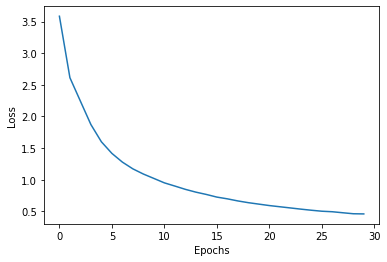

In [16]:
def train_txtsql():
    # Load training and validation (dev) dataset
    sql_data, table_data, TRAIN_DB = load_dataset("train")
    validation_sql_data, validation_table_data, DEV_DB = load_dataset("dev")

    # Load the glove word embeddings
    emb = load_word_embeddings('/content/drive/MyDrive/Data606_finalproject/data/glove.6B.300d.txt')

    # Initialize the target model with the word embeddings
    model = txtsql(emb, N_word=300, gpu=GPU)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Load the file names for the best models that we find during training
    aggregator_model, selection_model, condition_model = best_model_name()

    # Initialize the starting values of accuracy by running the model once without training
    init_acc = epoch_acc(model, BATCH_SIZE, validation_sql_data, validation_table_data)
    best_agg_acc = init_acc[1][0]
    best_agg_idx = 0
    best_sel_acc = init_acc[1][1]
    best_sel_idx = 0
    best_cond_acc = init_acc[1][2]
    best_cond_idx = 0
    print('Initial dev accuracy: %s\n  breakdown on (agg, sel, where): %s' % init_acc)

    # Save the untrained model as the initial best
    torch.save(model.sel_pred.state_dict(), selection_model)
    torch.save(model.agg_pred.state_dict(), aggregator_model)
    torch.save(model.cond_pred.state_dict(), condition_model)
    
    # Store the losses per epoch for loss curve
    epoch_losses = []

    for i in range(TRAINING_EPOCHS):
        print('Epoch :', i + 1)
        
        # Train the model on training dataset only
        epoch_loss = epoch_train(model, optimizer, BATCH_SIZE, sql_data, table_data)
        epoch_losses.append(epoch_loss)

        print('Loss =', epoch_loss)

        # Check model accuracy on training and validation set
        training_accuracy = epoch_acc(model, BATCH_SIZE, sql_data, table_data)
        print('Train accuracy: %s\n   breakdown result: %s' % training_accuracy)
        
        validation_accuracy = epoch_acc(model, BATCH_SIZE, validation_sql_data, validation_table_data)
        print('Dev accuracy: %s\n   breakdown result: %s' % validation_accuracy)
        
        # If the accuracy is better than the previous best, update the best scores and models
        if validation_accuracy[1][0] > best_agg_acc:
            best_agg_acc = validation_accuracy[1][0]
            best_agg_idx = i + 1
            torch.save(model.agg_pred.state_dict(), aggregator_model)
        if validation_accuracy[1][1] > best_sel_acc:
            best_sel_acc = validation_accuracy[1][1]
            best_sel_idx = i + 1
            torch.save(model.sel_pred.state_dict(), selection_model)
        if validation_accuracy[1][2] > best_cond_acc:
            best_cond_acc = validation_accuracy[1][2]
            best_cond_idx = i + 1
            torch.save(model.cond_pred.state_dict(), condition_model)

        print('Best val accuracy = %s, on epoch %s individually' % (
            (best_agg_acc, best_sel_acc, best_cond_acc),
            (best_agg_idx, best_sel_idx, best_cond_idx)))

    # save epoch vs loss graph
    plot_data(x = range(TRAINING_EPOCHS), y = epoch_losses, xlabel = "Epochs", ylabel = "Loss", label = "Loss Graph for target txtsql model")


if __name__ == '__main__':
    train_txtsql()

##**Function to test the model**

In [17]:

def test_txtsql():
    test_sql_data, test_table_data, TEST_DB = load_dataset("test")

    # load glove word embeddings and initialize the model
    emb = load_word_embeddings('/content/drive/MyDrive/Data606_finalproject/data/glove.6B.300d.txt')
    model = txtsql(emb, N_word=300, gpu=GPU)

    # Load the best model state saved during training
    agg_m, sel_m, cond_m = best_model_name()
    model.agg_pred.load_state_dict(torch.load(agg_m))
    model.sel_pred.load_state_dict(torch.load(sel_m))
    model.cond_pred.load_state_dict(torch.load(cond_m))

    # Run the model on the test data and get the logical accuracy
    logical_accuracy_score =\
        epoch_acc(model, BATCH_SIZE, test_sql_data, test_table_data, save_results = True)

    # Run the model on the test data and get the execution accuracy
    execution_accuracy_score =\
        epoch_exec_acc(model, BATCH_SIZE, test_sql_data, test_table_data, TEST_DB)
    
    print("Test logical accuracy: %s;\n  breakdown on (agg, sel, where): %s" % logical_accuracy_score)
    print("Test execution accuracy: %s" % execution_accuracy_score)


if __name__ == '__main__':
    test_txtsql()

Loading dataset :  test
Loading word embedding from /content/drive/MyDrive/Data606_finalproject/data/glove.6B.300d.txt
txtsql where prediction
Test logical accuracy: 0.47128101776042325;
  breakdown on (agg, sel, where): [0.90074317 0.87044968 0.56090188]
Test execution accuracy: 0.5537221312507873


References:
1. https://github.com/salesforce/WikiSQL
2. https://github.com/tiwarikajal/Seq2SQL--Natural-Language-sentences-to-SQL-Queries